In [1]:
from ccgcrv import ccg_filter
from ccgcrv import ccg_dates
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [2]:
def ccg_fits(data, pars):
    data = data.loc[data['co2_ppm'].notna(), :] # Data cannot have missing values.
    xp = data["dec_year"].to_numpy()
    yp = data["co2_ppm"].to_numpy()

    # create the ccgfilt object
    filt = ccg_filter.ccgFilter(xp=xp, yp=yp, shortterm=pars['shortterm'],
                                longterm=pars['longterm'], sampleinterval=pars['sampleinterval'],
                                numpolyterms=pars['numpolyterms'], numharmonics=pars['numharmonics'],
                                timezero=pars['timezero'], gap=pars['gap'], debug=pars['debug'])
    # filt = ccg_filter.ccgFilter(xp=xp, yp=yp)

    pred1 = pd.DataFrame({
        'x': xp,
        'func': filt.getFunctionValue(xp),
        'smooth': filt.getSmoothValue(xp),
        'trend': filt.getTrendValue(xp),
        'harm': filt.getHarmonicValue(xp),
        'poly': filt.getPolyValue(xp)
        })
    
    x0 = filt.xinterp
    pred2 = pd.DataFrame({
        'x0': x0,
        'func': filt.getFunctionValue(x0),
        'smooth': filt.getSmoothValue(x0),
        'trend': filt.getTrendValue(x0),
        'harm': filt.getHarmonicValue(x0),
        'poly': filt.getPolyValue(x0)
        })

    # mm = filt.getMonthlyMeans()
    amps = filt.getAmplitudes()
    yearly = pd.DataFrame(amps,
        columns=['year', 'amp', 'max_date', 'max_value', 'min_date', 'min_value']) # Returns a list of tuples, each tuple has 6 values (year, total_amplitude, max_date, max_value, min_date, min_value)

    tcup, tcdown = filt.getTrendCrossingDates()

    decyear = pd.Series(tcdown)
    cal = decyear.transform(ccg_dates.calendarDate)
    tcd = pd.DataFrame(cal.to_list(), 
        columns=['year', 'month', 'day', 'hour', 'minute', 'second'])
    tcd['doy'] = tcd.apply(lambda row: ccg_dates.dayOfYear(row['year'].astype(int),
        row['month'].astype(int), row['day'].astype(int)), axis=1)

    decyear = pd.Series(tcup)
    cal = decyear.transform(ccg_dates.calendarDate)
    tcu = pd.DataFrame(cal.to_list(),
        columns=['year', 'month', 'day', 'hour', 'minute', 'second'])
    tcu['doy'] = tcu.apply(lambda row: ccg_dates.dayOfYear(row['year'].astype(int),
        row['month'].astype(int), row['day'].astype(int)), axis=1)
    
    yearly['tcd_doy'] = tcd['doy']
    yearly['tcd_dec'] = pd.Series(tcdown)
    yearly['tcu_doy'] = tcu['doy']
    yearly['tcu_dec'] = pd.Series(tcup)

    out = {'pred_xobs':pred1, 'pred_xint':pred2, 'yearly':yearly}

    return(out)

In [3]:
# Default parameter values as used in the ccgcrv code.
ccg_pars_def = {
    'shortterm': 80,
    'longterm': 667,
    'sampleinterval': 0,
    'numpolyterms': 3,
    'numharmonics': 4,
    'timezero': -1,
    'gap': 0,
    'use_gain_factor': False,
    'debug': False
}

In [4]:
# Define a function to plot a regression line
def plot_linreg(x_in, y_in, col='grey', fmt='o', lab = '', alpha=0.7):
    from sklearn.linear_model import LinearRegression
    # import statsmodels.api as sma
    model = LinearRegression()  
    x = x_in.values.reshape(-1, 1) # sklearn fit requires a two dimensional array
    y = y_in.values.reshape(-1, 1)
    model.fit(x, y)
    y_pred = model.predict(x)
    r_sq = ": r_sq = {:.3f}".format(model.score(x, y))
    plt.plot(x, y, fmt, color=col, alpha=alpha,label=lab+r_sq)
    plt.plot(x, y_pred, '--', color=col)

In [5]:
def makeplots(ccg_fit):
    
    # Set plot size, etc
    plt.rcParams['figure.figsize'] = [15, 5]

    # Define some colors
    col_0 = 'aqua'
    col_1 = 'teal'
    col_2 = 'orchid'
    col_3 = 'indigo'

    # Plot data
    yrly = ccg_fit['yearly']
    plt.plot(yrly['year'], yrly['amp'], '-')
    plt.show()
    plt.plot(yrly['year'], yrly['tcd_doy']-180, '-', color=col_1, label='downward zero crossing (relative to DOY 180)')
    plt.plot(yrly['year'], yrly['tcu_doy']-320, '-', color=col_2, label='upward zero crossing (relative to DOY 320)')
    plt.legend(loc='upper right')
    plt.show()

#### Comparison of Time Series 
- Monthly vs Daily
- Flask vs In-Situ
- Observed vs Modelled

In [6]:
# Some settings

# Start and end years for analysis: select years to coincide with Joyce et al.
start_y = 1982
end_y = 2012

# Read in Joyce data
joyce_yrly = pd.read_csv('../data/ccgcrv_testing/BRW_SZC_JoyceGRL2021.csv')

joyce_monthly = pd.read_csv('../data/ccgcrv_testing/BRW_CO2_monthly_joyce_varyall.csv')
joyce_monthly['dec_year'] = np.round(joyce_monthly.apply(lambda row: ccg_dates.decimalDate(row['year'].astype(int),
        row['month'].astype(int), 1), axis=1), 2)

joyce_daily = pd.read_csv('../data/ccgcrv_testing/BRW_CO2_daily_joyce_varyall.csv')
joyce_daily['dec_year'] = np.round(joyce_daily.apply(lambda row: ccg_dates.decimalDate(row['year'].astype(int),
        row['month'].astype(int), row['day'].astype(int)), axis=1), 2)

joyce_hourly = pd.read_csv('../data/ccgcrv_testing/BRW_CO2_3hourly_joyce_constmet.csv')
joyce_hourly['dec_year'] = np.round(joyce_hourly.apply(lambda row: ccg_dates.decimalDate(row['year'].astype(int),
        row['month'].astype(int), row['day'].astype(int), row['hour'].astype(int)), axis=1), 2)


In [7]:
# Defining test parameter sets

# Set sampleinterval to 1
ccg_pars1 = ccg_pars_def
ccg_pars1['sampleinterval'] = 1

# Set sampleinterval to 1 and increase long and short term filters by 10%
ccg_pars2 = ccg_pars_def
ccg_pars2['sampleinterval'] = 1
ccg_pars2['shortterm'] = ccg_pars2['shortterm'] * 1.1
ccg_pars2['longterm'] = ccg_pars2['longterm'] * 1.1

# Set sampleinterval to 1 and decrease long and short term filters by 10%
ccg_pars3 = ccg_pars_def
ccg_pars3['sampleinterval'] = 1
ccg_pars3['shortterm'] = ccg_pars3['shortterm'] * 0.9
ccg_pars3['longterm'] = ccg_pars3['longterm'] * 0.9

In [8]:
# Pt Barrow - In-Situ - Daily
filein = '../data/ccgcrv_testing/brw-insitu_day.txt'
data = pd.read_csv(filein, delimiter = ' ', header = 0, names = ['dec_year', 'co2_ppm'])
data = data.loc[data['dec_year'].between(start_y, end_y), :] 
ccgfit_defpars_brw_daily_insitu = ccg_fits(data=data, pars=ccg_pars_def)

# Pt Barrow - In-Situ - Daily - Pars 1
filein = '../data/ccgcrv_testing/brw-insitu_day.txt'
data = pd.read_csv(filein, delimiter = ' ', header = 0, names = ['dec_year', 'co2_ppm'])
data = data.loc[data['dec_year'].between(start_y, end_y), :] 
ccgfit_pars1_brw_daily_insitu = ccg_fits(data=data, pars=ccg_pars1)

# Pt Barrow - In-Situ - Monthly
filein = '../data/ccgcrv_testing/brw-insitu_mon.txt'
data = pd.read_csv(filein, delimiter = ' ', header = 0, names = ['dec_year', 'co2_ppm'])
data = data.loc[data['dec_year'].between(start_y, end_y), :] 
ccgfit_defpars_brw_monthly_insitu = ccg_fits(data=data, pars=ccg_pars_def)

# Pt Barrow - In-Situ - Monthly - Pars 1
filein = '../data/ccgcrv_testing/brw-insitu_mon.txt'
data = pd.read_csv(filein, delimiter = ' ', header = 0, names = ['dec_year', 'co2_ppm'])
data = data.loc[data['dec_year'].between(start_y, end_y), :] 
ccgfit_pars1_brw_monthly_insitu = ccg_fits(data=data, pars=ccg_pars1)

# Pt Barrow - Flask - Monthly - Pars 1
filein = '../data/ccgcrv_testing/brw-flask_mon.txt'
data = pd.read_csv(filein, delimiter = ' ', header = 0, names = ['dec_year', 'co2_ppm'])
data = data.loc[data['dec_year'].between(start_y, end_y), :] 
ccgfit_pars1_brw_monthly_flask = ccg_fits(data=data, pars=ccg_pars1)

# Pt Barrow - TOMCAT (Joyce) - Monthly - Pars 1
data = joyce_monthly
data = data.loc[data['dec_year'].between(start_y, end_y), :] 
ccgfit_pars1_brw_monthly_tomcat = ccg_fits(data=data, pars=ccg_pars1)

# Pt Barrow - TOMCAT (Joyce) - Daily - Pars 1
data = joyce_daily
data = data.loc[data['dec_year'].between(start_y, end_y), :] 
ccgfit_pars1_brw_daily_tomcat = ccg_fits(data=data, pars=ccg_pars1)

# Pt Barrow - TOMCAT (Joyce) - Daily - Pars 1
data = joyce_hourly
data = data.loc[data['dec_year'].between(start_y, end_y), :] 
ccgfit_pars1_brw_hourly_tomcat = ccg_fits(data=data, pars=ccg_pars1)


In [9]:
# Comparisons plots of amplitudes and ZC

    # Set plot size, etc
plt.rcParams['figure.figsize'] = [12, 5]

# Define some colors
col_0 = 'aqua'
col_1 = 'teal'
col_2 = 'orchid'
col_3 = 'indigo'
col_4 = 'blue'
col_5 = 'yellowgreen'
col_6 = 'orange'
col_7 = 'olive'
col_8 = 'khaki'

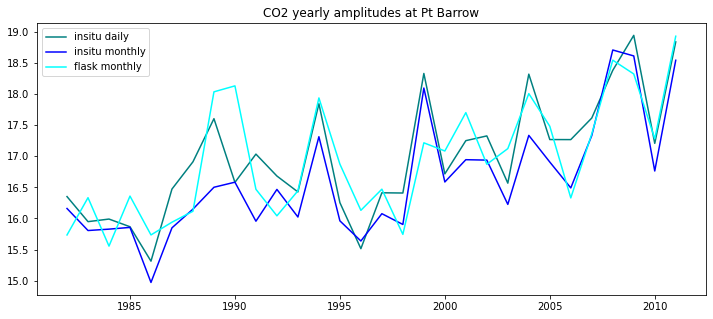

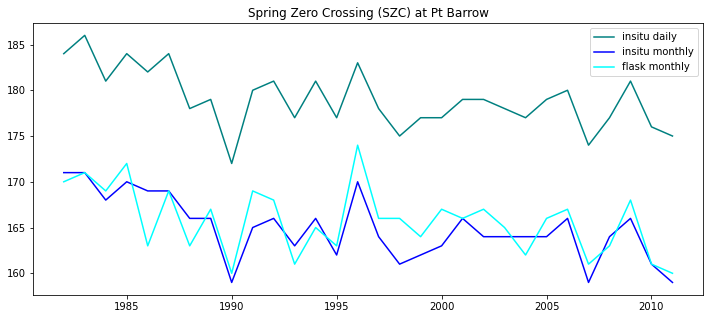

In [14]:

# Compare monthly vs daily and insitu vs flask
# In the following, all cases using sampleinterval=1 

p1_brw_dai_is = ccgfit_pars1_brw_daily_insitu['yearly']
p1_brw_mon_is = ccgfit_pars1_brw_monthly_insitu['yearly']
p1_brw_mon_fl = ccgfit_pars1_brw_monthly_flask['yearly']

plt.plot(p1_brw_dai_is['year'], p1_brw_dai_is['amp'], '-', color=col_1, label='insitu daily')
plt.plot(p1_brw_mon_is['year'], p1_brw_mon_is['amp'], '-', color=col_4, label='insitu monthly')
plt.plot(p1_brw_mon_fl['year'], p1_brw_mon_fl['amp'], '-', color=col_0, label='flask monthly')
plt.title(label='CO2 yearly amplitudes at Pt Barrow')
plt.legend(loc='upper left')
plt.show()

plt.plot(p1_brw_dai_is['year'], p1_brw_dai_is['tcd_doy'], '-', color=col_1, label='insitu daily')
plt.plot(p1_brw_mon_is['year'], p1_brw_mon_is['tcd_doy'], '-', color=col_4, label='insitu monthly')
plt.plot(p1_brw_mon_fl['year'], p1_brw_mon_fl['tcd_doy'], '-', color=col_0, label='flask monthly')
# plt.ylim(top=max(dp_brw_dai_is['tcd_doy'])*1.1)
plt.title(label='Spring Zero Crossing (SZC) at Pt Barrow')
plt.legend(loc='upper right')
plt.show()


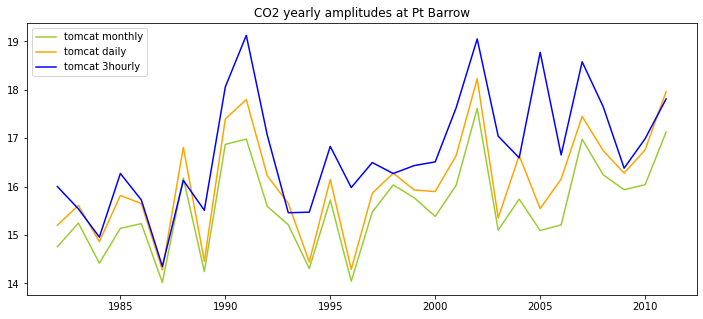

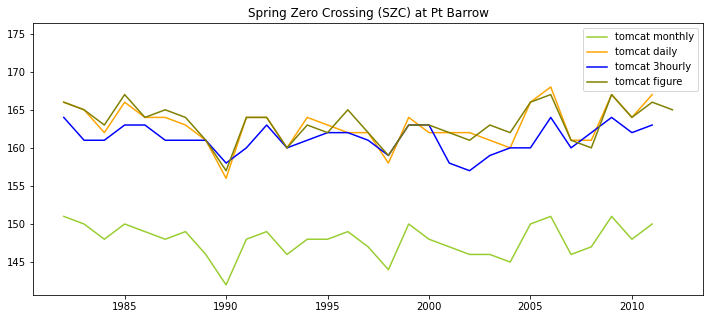

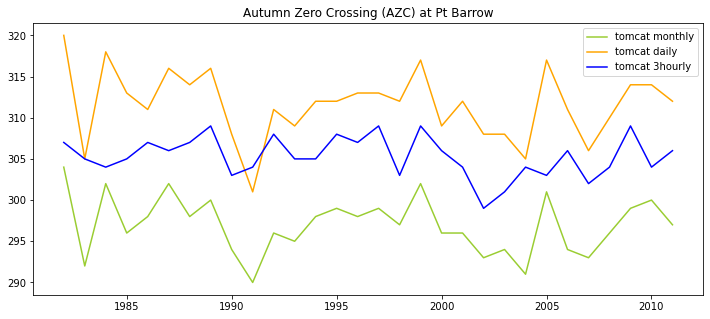

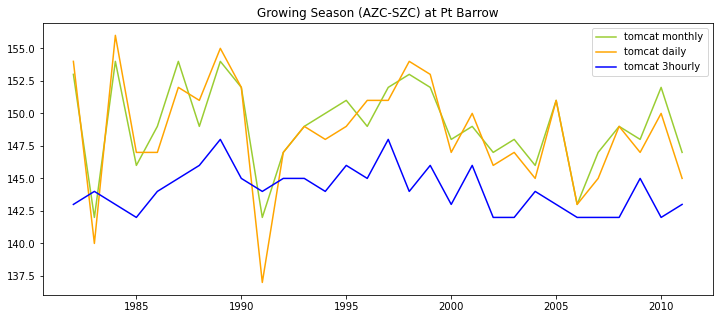

KeyError: ''

In [15]:

# Compare Joyce data (tomcat calculated vs figure)

p1_brw_hou_tc = ccgfit_pars1_brw_hourly_tomcat['yearly']
p1_brw_dai_tc = ccgfit_pars1_brw_daily_tomcat['yearly']
p1_brw_mon_tc = ccgfit_pars1_brw_monthly_tomcat['yearly']

# Plot amplitudes
plt.plot(p1_brw_mon_tc['year'], p1_brw_mon_tc['amp'], '-', color=col_5, label='tomcat monthly')
plt.plot(p1_brw_dai_tc['year'], p1_brw_dai_tc['amp'], '-', color=col_6, label='tomcat daily')
plt.plot(p1_brw_hou_tc['year'], p1_brw_hou_tc['amp'], '-', color=col_4, label='tomcat 3hourly')
plt.title(label='CO2 yearly amplitudes at Pt Barrow')
plt.legend(loc='upper left')
plt.show()

# Plot spring zero crossing (SZC)
plt.plot(p1_brw_mon_tc['year'], p1_brw_mon_tc['tcd_doy'], '-', color=col_5, label='tomcat monthly')
plt.plot(p1_brw_dai_tc['year'], p1_brw_dai_tc['tcd_doy'], '-', color=col_6, label='tomcat daily')
plt.plot(p1_brw_hou_tc['year'], p1_brw_hou_tc['tcd_doy'], '-', color=col_4, label='tomcat 3hourly')
plt.plot(joyce_yrly['year'], joyce_yrly['szc_tomcat_fig'], '-', color=col_7, label='tomcat figure')
plt.ylim(top=max(p1_brw_dai_tc['tcd_doy'])*1.05)
plt.title(label='Spring Zero Crossing (SZC) at Pt Barrow')
plt.legend(loc='upper right')
plt.show()

# Plot autumn zero crossing (AZC)
plt.plot(p1_brw_mon_tc['year'], p1_brw_mon_tc['tcu_doy'], '-', color=col_5, label='tomcat monthly')
plt.plot(p1_brw_dai_tc['year'], p1_brw_dai_tc['tcu_doy'], '-', color=col_6, label='tomcat daily')
plt.plot(p1_brw_hou_tc['year'], p1_brw_hou_tc['tcu_doy'], '-', color=col_4, label='tomcat 3hourly')
# plt.ylim(top=max(dp_brw_dai_is['tcu_doy'])*1.05)
plt.title(label='Autumn Zero Crossing (AZC) at Pt Barrow')
plt.legend(loc='upper right')
plt.show()

# Plot AZC - SZC (growing season)
plt.plot(p1_brw_mon_tc['year'], p1_brw_mon_tc['tcu_doy'] - p1_brw_mon_tc['tcd_doy'], '-', color=col_5, label='tomcat monthly')
plt.plot(p1_brw_dai_tc['year'], p1_brw_dai_tc['tcu_doy'] - p1_brw_dai_tc['tcd_doy'], '-', color=col_6, label='tomcat daily')
plt.plot(p1_brw_hou_tc['year'], p1_brw_hou_tc['tcu_doy'] - p1_brw_hou_tc['tcd_doy'], '-', color=col_4, label='tomcat 3hourly')
# plt.ylim(top=max(dp_brw_dai_is['tcu_doy'])*1.05)
plt.title(label='Growing Season (AZC-SZC) at Pt Barrow')
plt.legend(loc='upper right')
plt.show()

# Plot tomcat from figure vs tomcat calculated
# plot_linreg(p1_brw_dai_is[''], , fmt='-', col=col_1, lab='insitu daily', alpha=1)


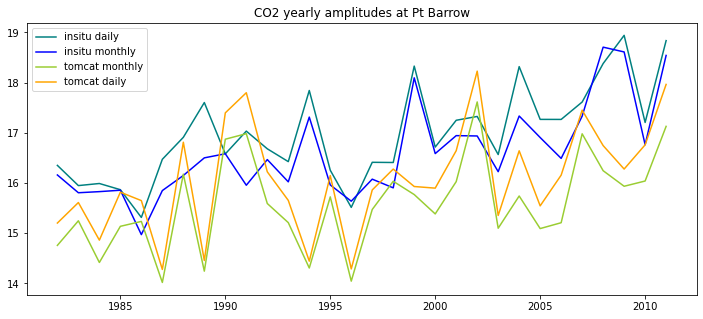

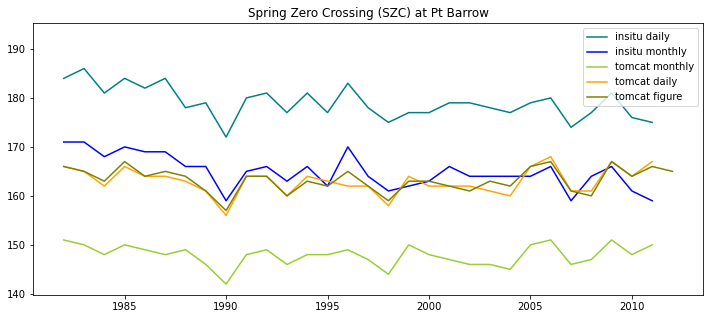

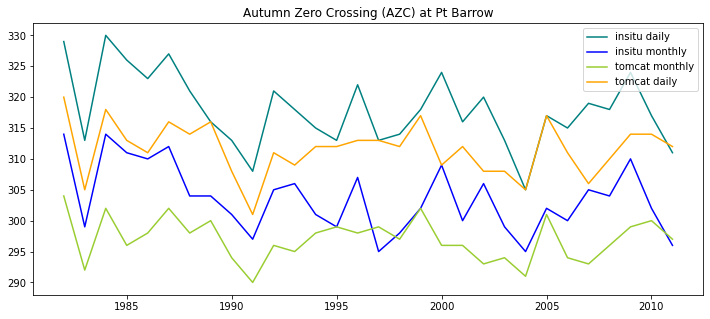

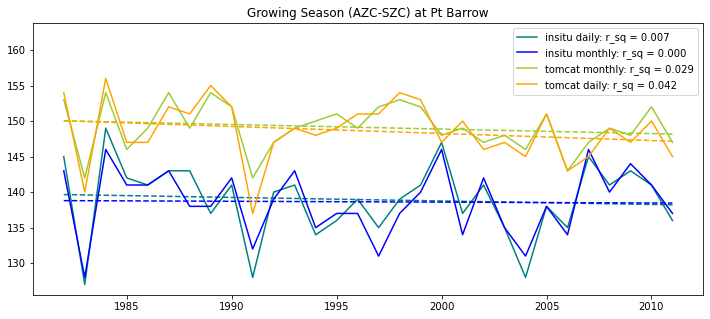

KeyError: ''

In [13]:

# Compare observed vs tomcat (Joyce data)

p1_brw_dai_is = ccgfit_pars1_brw_daily_insitu['yearly']
p1_brw_mon_is = ccgfit_pars1_brw_monthly_insitu['yearly']
p1_brw_dai_tc = ccgfit_pars1_brw_daily_tomcat['yearly']
p1_brw_mon_tc = ccgfit_pars1_brw_monthly_tomcat['yearly']

# Plot amplitudes
plt.plot(p1_brw_dai_is['year'], p1_brw_dai_is['amp'], '-', color=col_1, label='insitu daily')
plt.plot(p1_brw_mon_is['year'], p1_brw_mon_is['amp'], '-', color=col_4, label='insitu monthly')
plt.plot(p1_brw_mon_tc['year'], p1_brw_mon_tc['amp'], '-', color=col_5, label='tomcat monthly')
plt.plot(p1_brw_dai_tc['year'], p1_brw_dai_tc['amp'], '-', color=col_6, label='tomcat daily')
plt.title(label='CO2 yearly amplitudes at Pt Barrow')
plt.legend(loc='upper left')
plt.show()

# Plot spring zero crossing (SZC)
plt.plot(p1_brw_dai_is['year'], p1_brw_dai_is['tcd_doy'], '-', color=col_1, label='insitu daily')
plt.plot(p1_brw_mon_is['year'], p1_brw_mon_is['tcd_doy'], '-', color=col_4, label='insitu monthly')
plt.plot(p1_brw_mon_tc['year'], p1_brw_mon_tc['tcd_doy'], '-', color=col_5, label='tomcat monthly')
plt.plot(p1_brw_dai_tc['year'], p1_brw_dai_tc['tcd_doy'], '-', color=col_6, label='tomcat daily')
plt.plot(joyce_yrly['year'], joyce_yrly['szc_tomcat_fig'], '-', color=col_7, label='tomcat figure')
plt.ylim(top=max(p1_brw_dai_is['tcd_doy'])*1.05)
plt.title(label='Spring Zero Crossing (SZC) at Pt Barrow')
plt.legend(loc='upper right')
plt.show()

# Plot autumn zero crossing (AZC)
plt.plot(p1_brw_dai_is['year'], p1_brw_dai_is['tcu_doy'], '-', color=col_1, label='insitu daily')
plt.plot(p1_brw_mon_is['year'], p1_brw_mon_is['tcu_doy'], '-', color=col_4, label='insitu monthly')
plt.plot(p1_brw_mon_tc['year'], p1_brw_mon_tc['tcu_doy'], '-', color=col_5, label='tomcat monthly')
plt.plot(p1_brw_dai_tc['year'], p1_brw_dai_tc['tcu_doy'], '-', color=col_6, label='tomcat daily')

# plt.ylim(top=max(p1_brw_dai_is['tcu_doy'])*1.05)
plt.title(label='Autumn Zero Crossing (AZC) at Pt Barrow')
plt.legend(loc='upper right')
plt.show()

# Plot AZC - SZC (growing season)
plot_linreg(p1_brw_dai_is['year'], p1_brw_dai_is['tcu_doy'] - p1_brw_dai_is['tcd_doy'], fmt='-', col=col_1, lab='insitu daily', alpha=1)
plot_linreg(p1_brw_mon_is['year'], p1_brw_mon_is['tcu_doy'] - p1_brw_mon_is['tcd_doy'], fmt='-', col=col_4, lab='insitu monthly', alpha=1)
plot_linreg(p1_brw_mon_tc['year'], p1_brw_mon_tc['tcu_doy'] - p1_brw_mon_tc['tcd_doy'], fmt='-', col=col_5, lab='tomcat monthly', alpha=1)
plot_linreg(p1_brw_dai_tc['year'], p1_brw_dai_tc['tcu_doy'] - p1_brw_dai_tc['tcd_doy'], fmt='-', col=col_6, lab='tomcat daily', alpha=1)
plt.ylim(top=max(p1_brw_dai_tc['tcu_doy'] - p1_brw_dai_tc['tcd_doy'])*1.05)
plt.title(label='Growing Season (AZC-SZC) at Pt Barrow')
plt.legend(loc='upper right')
plt.show()
